In [1]:
# from tqdm import tqdm
from tqdm.notebook import tqdm

import json 
import pandas as pd
import polars as pl
import unicodedata

import polars as pl
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sentence_transformers import SentenceTransformer

import matplotlib.pyplot as plt

from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler

In [2]:
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        # embeddings: list of numpy arrays or torch tensors
        # labels: list of scalars
        self.X = torch.tensor(embeddings, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.float16)  # or long, depending on your task
       
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [3]:
val = torch.load("../data/2_training_ready/mymethod/take00/val.pt")

/tmp/ipykernel_6037/4087980410.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  val = torch.load("../data/2_training_ready/mymethod/take00/val.pt")


In [4]:
!ls ../data/2_training_ready/mymethod/take00

testing.pt  training1.pt  training2.pt	training3.pt  training4.pt  val.pt


In [5]:
testing = torch.load("../data/2_training_ready/mymethod/take00/testing.pt") # TESTING

/tmp/ipykernel_6037/1631147067.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  testing = torch.load("../data/2_training_ready/mymethod/take00/testing.pt") # TESTING


In [6]:
training1 = torch.load("../data/2_training_ready/mymethod/take00/training1.pt")
training2 = torch.load("../data/2_training_ready/mymethod/take00/training2.pt")
training3 = torch.load("../data/2_training_ready/mymethod/take00/training3.pt")
training4 = torch.load("../data/2_training_ready/mymethod/take00/training4.pt")

/tmp/ipykernel_6037/4131447330.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training1 = torch.load("../data/2_training_ready/mymethod/take00/training1.pt")
/tmp/ipyke

In [7]:
# # Combine the embeddings and labels
combined_embeddings = torch.cat([training1.X, training2.X, training3.X,training4.X], dim=0)
combined_labels = torch.cat([training1.y, training2.y, training3.y,training4.y], dim=0)
# 
# # Create a new EmbeddingDataset with the combined data
training = EmbeddingDataset(combined_embeddings.numpy(), combined_labels.numpy())

In [8]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim=4_096, hidden_dim_1=2_048,hidden_dim_2=1_024, output_dim=5, dropout=0.2):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim_1),
            nn.LayerNorm(hidden_dim_1),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            # nn.Linear(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim_1, hidden_dim_2),
            nn.LayerNorm(hidden_dim_2),
            nn.LeakyReLU(),
            nn.Dropout(dropout/2),
            nn.Linear(hidden_dim_2, output_dim)
        )

    def forward(self, x):
        return self.model(x)


In [9]:
# Set up your dataset and dataloaders
batch_size = 1_024
train_loader = DataLoader(training, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testing, batch_size=batch_size, shuffle=False)


In [10]:
# Convert dataset labels to integers (class indices)
training.y = training.y.long()  # Keep 1-based indexing for star ratings
testing.y = testing.y.long()  # Keep 1-based indexing for star ratings
val.y = val.y.long()

In [11]:
# Define model, loss function, and optimizer
input_dim = training.X.shape[1]  # Number of features in the embeddings
hidden_dim = 2048
output_dim = len(torch.unique(training.y))  # Number of classes

# model = SimpleNN(input_dim, hidden_dim, output_dim).to("cuda")
model = SimpleNN(input_dim=4096, hidden_dim_1=2048, hidden_dim_2=1024, output_dim=5).to("cuda")
criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=1e-2) # , weight_decay=1e-5
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.631)

In [12]:
class FlatLRScheduler(_LRScheduler):
    def __init__(self, optimizer: Optimizer, schedule: list, last_epoch: int = -1):
        """
        Custom Learning Rate Scheduler.

        Args:
            optimizer (Optimizer): Wrapped optimizer.
            schedule (list): List of tuples defining (epoch_range, lr_value).
                             Example: [(9, 1e-3), (8, 1e-4), (8, 1e-5)]
            last_epoch (int): The index of the last epoch. Default is -1.
        """
        self.schedule = []
        total_epochs = 0
        for epochs, lr in schedule:
            total_epochs += epochs
            self.schedule.append((total_epochs, lr))
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        current_epoch = self.last_epoch + 1
        for end_epoch, lr in self.schedule:
            if current_epoch <= end_epoch:
                return [lr for _ in self.optimizer.param_groups]
        raise ValueError(f"Epoch {current_epoch} is out of range for the provided schedule.")

# Define the schedule: [(9 epochs at 1e-3), (8 epochs at 1e-4), (8 epochs at 1e-5)]
# schedule = [(1, 1e-3), (10, 1e-4),(10, 5e-5), (100, 1e-5)] # THIS SHOULD BE ONE LONGER THAN NUM_EPOCHS TO AVOID OFF BY ONE ERROR
# schedule = [(1, 1e-3), (1, 1e-4),(10, 1e-5), (100, 1e-6)] # THIS SHOULD BE ONE LONGER THAN NUM_EPOCHS TO AVOID OFF BY ONE ERROR
schedule = [(10, 1e-2), (10, 1e-3),(10, 1e-4), (100, 1e-5)] # THIS SHOULD BE ONE LONGER THAN NUM_EPOCHS TO AVOID OFF BY ONE ERROR

# Initialize the custom scheduler
scheduler = FlatLRScheduler(optimizer, schedule)


In [13]:
# from torch.optim.lr_scheduler import ReduceLROnPlateau
# scheduler = ReduceLROnPlateau(
#     optimizer,
#     mode='min',       # Use 'min' if your metric is loss; 'max' if accuracy or some metric you want to maximize
#     factor=0.1,       # Factor by which the learning rate will be reduced (new_lr = lr * factor)
#     patience=10,      # Number of epochs to wait before reducing LR
#     threshold=1e-4,   # Threshold for measuring improvement
#     verbose=True      # Prints a message when the LR is reduced
# )

In [14]:
# Training and evaluation loops
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to("cuda")
            y = y.to("cuda")
            outputs = model(X)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted + 1 == y).sum().item()  # Adjust prediction for 1-based indexing
            total += y.size(0)
    accuracy = correct / total
    return accuracy


In [15]:
# num_epochs = 10
num_epochs = 5
# log_interval = 1_500
# log_interval = 3332

In [16]:
step = 0

train_losses = []
eval_accuracies = []
learning_rates = []  # New list to track learning rates

for epoch in range(num_epochs):
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append((epoch, current_lr))
    # learning_rates.append(current_lr)

    model.train()

    running_loss = 0.0
    for X, y in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):

        X = X.to("cuda")
        y = y.to("cuda")
        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, y - 1)  # Shift labels for 0-based indexing during training

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()*X.shape[0]
        step += 1

    train_losses.append(running_loss / len(train_loader))
    scheduler.step()


    # Log progress every epoch
    eval_accuracy = evaluate(model, test_loader)
    eval_accuracies.append((step, eval_accuracy))
    print(f"Epoch {epoch+1}, Eval Accuracy: {eval_accuracy:.4f}")

    # scheduler.step(eval_accuracy)



Epoch 1/5:   0%|          | 0/831 [00:00<?, ?it/s]

Epoch 1, Eval Accuracy: 0.7169


Epoch 2/5:   0%|          | 0/831 [00:00<?, ?it/s]

Epoch 2, Eval Accuracy: 0.7229


Epoch 3/5:   0%|          | 0/831 [00:00<?, ?it/s]

Epoch 3, Eval Accuracy: 0.7271


Epoch 4/5:   0%|          | 0/831 [00:00<?, ?it/s]

Epoch 4, Eval Accuracy: 0.7226


Epoch 5/5:   0%|          | 0/831 [00:00<?, ?it/s]

Epoch 5, Eval Accuracy: 0.7243


In [17]:
# # FIRST TRY, GARBAGE
# step = 0
#
# train_losses = []
# eval_accuracies = []
# learning_rates = []  # New list to track learning rates
#
# for epoch in range(num_epochs):
#     current_lr = optimizer.param_groups[0]['lr']
#     learning_rates.append((epoch, current_lr))
#     # learning_rates.append(current_lr)
#
#     model.train()
#     pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")
#     running_loss = 0.0
#
#     for X, y in pbar:
#         X = X.to("cuda")
#         y = y.to("cuda")
#         # Forward pass
#         outputs = model(X)
#         loss = criterion(outputs, y - 1)  # Shift labels for 0-based indexing during training
#
#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#
#
#         running_loss += loss.item()
#         step += 1
#
#         # Log progress every log_interval steps
#         if step % log_interval == 0:
#             eval_accuracy = evaluate(model, test_loader)
#             eval_accuracies.append((step, eval_accuracy))
#             print(f"Step {step}, Loss: {loss.item():.4f}, Eval Accuracy: {eval_accuracy:.4f}")
#
#     train_losses.append(running_loss / len(train_loader))
#     scheduler.step()
#


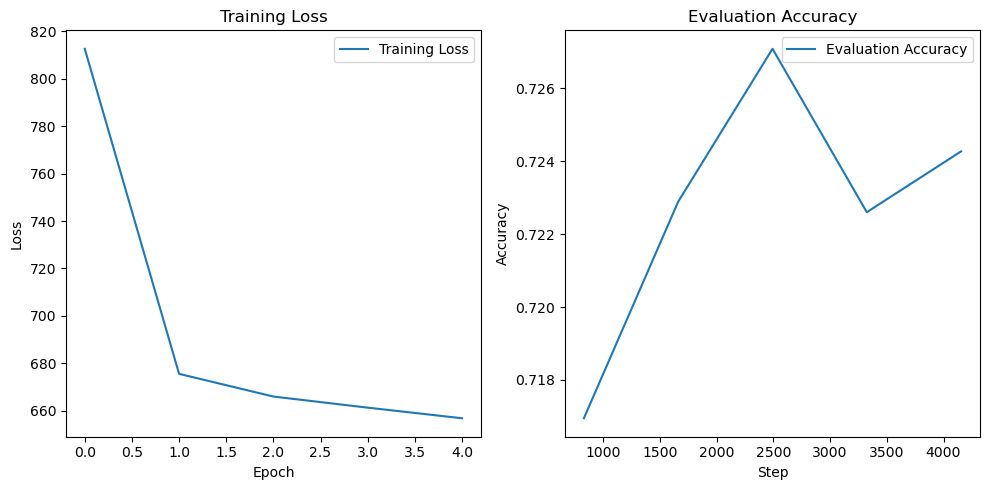

In [18]:
# Plot training loss and evaluation accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss")

plt.subplot(1, 2, 2)
steps, accuracies = zip(*eval_accuracies)
plt.plot(steps, accuracies, label="Evaluation Accuracy")
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Evaluation Accuracy")

plt.tight_layout()
plt.show()


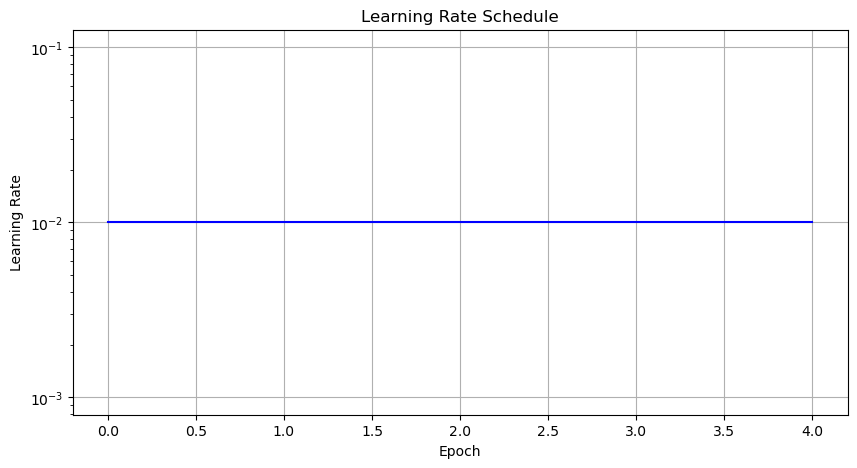

In [19]:
epochs, lrs = zip(*learning_rates)
plt.figure(figsize=(10, 5))
plt.plot(epochs, lrs, 'b-')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True)
plt.show()

In [ ]:
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to("cuda")
            y = y.to("cuda")
            outputs = model(X)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted + 1 == y).sum().item()  # Adjust prediction for 1-based indexing
            total += y.size(0)
    accuracy = correct / total
    return accuracy

In [20]:
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)

In [31]:
predictions = []
correct_values = []
model.eval()
with torch.no_grad():
    for batch_x, batch_y in tqdm(val_loader, desc="Hit Rate Eval", unit="batch"):
        # batch_y = torch.argmax(batch_y, dim=1)

        batch_x = batch_x.to("cuda")
        batch_y = batch_y.to("cuda")

        pred = model(batch_x)

        # Compute hit rate
        y_pred_classes = torch.argmax(torch.softmax(pred, dim=1), dim=1)
        # y_true_classes = torch.argmax(batch_y, dim=1) # TK TK ADD BACK FOR EMD

        for i in [i.item() for i in torch.argmax(torch.softmax(pred, dim=1), dim=1)]:
            predictions.append(i+1)
        for i in [i.item() for i in batch_y]: # torch.argmax(batch_y, dim=1):
            correct_values.append(i)

Hit Rate Eval:   0%|          | 0/1 [00:00<?, ?batch/s]

In [32]:
df = pl.DataFrame({"true": correct_values, "predicted": predictions})
df.write_csv("../output/predictions/mymethod00.csv")

In [33]:
n,d=0,0
for a, b in zip(df["true"].to_list(), df["predicted"].to_list()):
    if a==b:
        n=n+1
    d=d+1
n/d

0.7200392927308448

In [34]:
min(df["predicted"]), max(df["predicted"])

(1, 5)

In [35]:
min(df["true"]), max(df["true"])

(1, 5)